# Diffraction for Circular Aperture

In [1]:
#Enable matplotlib and pylab functions to work directly in this notebook
%matplotlib inline
%pylab inline

#Refreshes changes in libraries to be reloaded when they are re-imported
%load_ext autoreload
%autoreload 2

#Import useful modules
import matplotlib
import numpy as np
import time
import os
#Add library path of this repository
sys.path.append(os.path.realpath('../lib'))

#from scipy import ndimage

#Set plotting defaults in notebook
from matplotlib import rcParams
rcParams["font.size"] = "15"

Populating the interactive namespace from numpy and matplotlib


Then define the parameters for the diffraction experiment. All the symbols have their usual meaning (refer to chapter 4 section 4.4.2). 

In [44]:
class diffractor(object):
    def __init__(self, waveLen, det_pix_size, N_pix=128):
        """
        Dushan inserts comments.
        """
        self.waveLen      = waveLen
        self.k            = 2.*np.pi/waveLen

        # since we fix the pixel size and number of pixels at the detector plane (i.e. xy plane),
        self.N_pix        = N_pix                   # number of detector pixels
        self.det_pix_size = det_pix_size            # pixel size at the detector
        self.det_len      = det_pix_size*self.N_pix # detector plane size
        (self.det_x, self.det_y) = self.make2Dplane(self.det_len, self.N_pix)

        self.obj = None
        self.det_pattern = None
        self.obj_pix = None
        self.xi = None
        self.eta = None
        self.res = None
        self.z = None
        self.curr_aperture_rad = None
        
    def compute_resolution(self, z):
        """
        We compute the resolution
        """
        return self.waveLen*z / (self.det_pix_size*self.N_pix)

    def compute_Fresnel_criterion(self, z):
        pass
        
    def compute_Fraunhofer_criterion(self, z):
        pass

    def make2Dplane(self, Lx, N):
        (x,y) = np.mgrid[-Lx/2:Lx/2:N*1j,-Lx/2:Lx/2:N*1j]
        return (x,y)

    def setup_detector_distance(self, z):
        # once the detector size and its pixel size are fixed it relates to the illumination plane by the Fourier Transform
        # See equation 4-17 (Goodman, chapter4)
        self.z   = z
        self.res = self.compute_resolution(z)
        # compute if we are in the Fresnel or Fraunhofer limit
    
    def make_circ_aperture(self, aperture_rad):
        if self.z is None:
            print("Please setup detector distance")
        else: 
            max_aperture_radius = 0.5*self.res*self.N_pix
            if aperture_rad >= max_aperture_radius:
                print("Aperture radius larger than max: %e"%(max_aperture_radius))
                print("Will use max aperture radius instead")
                self.curr_aperture_rad = max_aperture_radius
            elif aperture_rad < self.res:
                print("Aperture radius smaller than pixel res: %e"%(self.res))
                print("Will use pixel size as radius instead")
                self.curr_aperture_rad = self.res
            else:
                self.curr_aperture_rad = 0.98*aperture_rad
            (self.xi, self.eta) = self.make2Dplane(2*max_aperture_radius, self.N_pix)
            self.obj = np.sqrt(self.xi*self.xi + self.eta*self.eta) < self.curr_aperture_rad
    
    def make_square_aperture(self, aperture_rad):
        if self.z is None:
            print("Please setup detector distance")
        else: 
            max_aperture_radius = 0.5*self.res*self.N_pix
            if aperture_rad >= max_aperture_radius:
                print("Aperture radius larger than max: %e"%(max_aperture_radius))
                print("Will use max aperture radius instead")
                self.curr_aperture_rad = max_aperture_radius
            elif aperture_rad < self.res:
                print("Aperture radius smaller than pixel res: %e"%(self.res))
                print("Will use pixel size as radius instead")
                self.curr_aperture_rad = self.res
            else:
                self.curr_aperture_rad = aperture_rad
            (self.xi, self.eta) = self.make2Dplane(2*max_aperture_radius, self.N_pix)
            self.obj = (np.abs(self.xi) < self.curr_aperture_rad)&(np.abs(self.eta) < self.curr_aperture_rad)
    
    def Fresnel(self, showPhase=False):
        if (self.z is None)|(self.obj is None):
            print("Please setup detector distance or initiate object")
        else:
            quad_phase     = np.exp(1j*self.k*(self.xi*self.xi + self.eta*self.eta)/(2.*self.z))
            overall_phase  = np.exp(1j*self.k*(self.det_x*self.det_x + self.det_y*self.det_y)/(2*self.z)) 
            fall_off       = np.exp(1j*self.k*self.z) / (1j*self.waveLen*self.z)
            U = overall_phase * fall_off * np.fft.fftshift(np.fft.fft2(quad_phase*self.obj))
            self.det_pattern = U.copy()
            if showPhase:
                return U
            else:
                return abs(U)**2

    def Fraunhofer(self, showPhase=False):
        if (self.z is None)|(self.obj is None):
            print("Please setup detector distance or initiate object")
        else:
            fall_off = np.exp(1j*self.k*self.z) / (1j*self.waveLen*self.z)
            U = fall_off * np.fft.fftshift(np.fft.fft2(self.obj))
            self.det_pattern = U.copy()
            if showPhase:
                return U
            else:
                return abs(U)**2
            
    def Rayleigh_Sommerfeld(self, showPhase=False):
        if (self.z is None)|(self.obj is None):
            print("Please setup detector distance or initiate object")
        else:
            (xx,yy) =  (self.det_x.flatten(), self.det_y.flatten())
            obj = self.obj.flatten()
            xi  = np.extract(obj==True, self.xi.ravel())
            eta = np.extract(obj==True, self.eta.ravel())
            obj = np.extract(obj==True, obj)
            output = np.zeros(self.obj.flatten().shape, dtype=np.complex64)

            for n,(x,y) in enumerate(zip(xx,yy)):
                tmp = self.z*self.z + (x-xi)**2 + (y-eta)**2
                sq = 1.j*self.k*np.sqrt(tmp)
                ee = np.exp(sq)/tmp
                output[n] = np.dot(obj, ee)
            return output.reshape(self.obj.shape)

            

def show_diffraction_series(scatterer, fres, fraun, res, 
                            tt0="scatterer", 
                            tt1="Fresnel diffraction", 
                            tt2="Fraunhofer diffraction",
                            res_unit=1.E-6):
    (fig, ax) = subplots(1,3,figsize=(18,6))

    ax[0].imshow(scatterer, cmap=cm.bone)
    ax[0].set_title(tt0)
    ax[0].set_ylabel("pixel size (%0.2lf um)"%(res/res_unit))
    ax[0].set_xlabel("pixel size (%0.2lf um)"%(res/res_unit))

    ax[1].set_title(tt1)
    ax[1].imshow(fres)

    ax[2].set_title(tt2)
    ax[2].imshow(fraun)

# When to use which approximation?

## Fresnel approximation
Only beyond a certain detector-specimen separation does the quadratic phase-factor in the diffraction formula (Goodman eqn. 4-18) varies sufficiently slowly for Fresnel approximation to work (read the discussion following Goodman eqn. 4-18). Loosely speaking we want $2 r < 4 \sqrt{\lambda z}$. To evaluate this criterion, we consider the "Fresnel number", $ z  \; / \; (0.25 r^2 / \lambda)$. Only when this Fresnel number is much larger than one is Fresnel approximation justified.

## Fraunhofer approximation
Here we apply the stronger constraint that the quadratic phase-factor in the diffraction formula is approximately constant. To evaluate this criterion, we consider the "Fraunhofer number" $z \; / \;(\pi r^2 / \lambda)$. Only when the Fraunhofer number is much larger than one is Fraunhofer diffraction justified.

## Here, Fresnel approximation works but Fraunhofer fails.
Thus only the Fresnel diffraction pattern is appropriate.

Fresnel number:  2.22222222222
Fraunhofer number: 0.176838825658


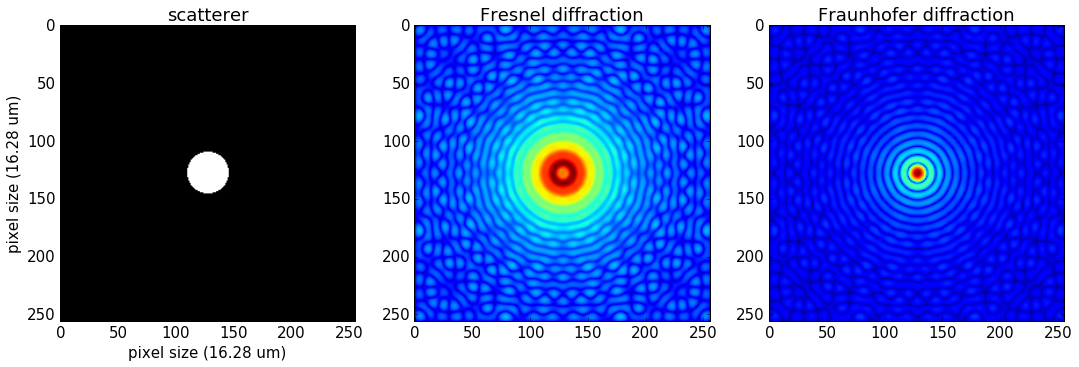

In [52]:
waveLen = 500E-9
pixelSize = 12.E-6
r = 300.E-6
z = .1

diffObj = diffractor(waveLen, pixelSize, N_pix=256)
diffObj.setup_detector_distance(z)
diffObj.make_circ_aperture(r)
#diffObj.make_square_aperture(r)
print "Fresnel number: ", diffObj.z / (0.25*r*r/waveLen)
print "Fraunhofer number:",diffObj.z / (np.pi*r*r/waveLen)

scatterer = diffObj.obj
fresnel_pattern = np.abs(diffObj.Fresnel())**0.2
fraunhofer_pattern = np.abs(diffObj.Fraunhofer())**0.2

show_diffraction_series(scatterer, fresnel_pattern, fraunhofer_pattern, diffObj.res)

## Below, both Fresnel and Fraunhofer approximations work.
Thus they generate similar diffraction patterns.

Fresnel number:  90.0
Fraunhofer number: 7.16197243914


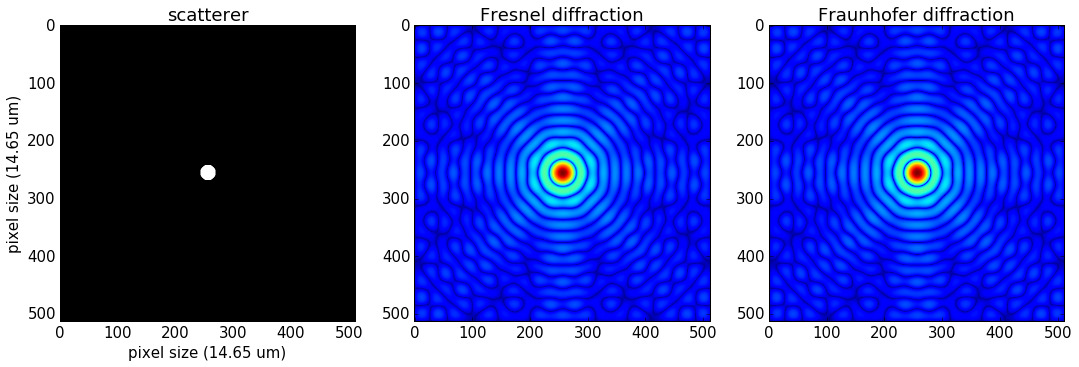

In [53]:
waveLen = 500E-9
pixelSize = 120.E-6
r = 200.E-6
z = 1.8

diffObj = diffractor(waveLen, pixelSize, N_pix=512)
diffObj.setup_detector_distance(z)
diffObj.make_circ_aperture(r)
print "Fresnel number: ", diffObj.z / (0.25*r*r/waveLen)
print "Fraunhofer number:",diffObj.z / (np.pi*r*r/waveLen)

scatterer = diffObj.obj
fresnel_pattern = np.abs(diffObj.Fresnel())**0.2
fraunhofer_pattern = np.abs(diffObj.Fraunhofer())**0.2

show_diffraction_series(scatterer, fresnel_pattern, fraunhofer_pattern, diffObj.res)

## Here we look at the differences between Fresnel and Rayleigh-Sommerfeld diffraction

Fresnel number:  7.5
Took 220.8 s


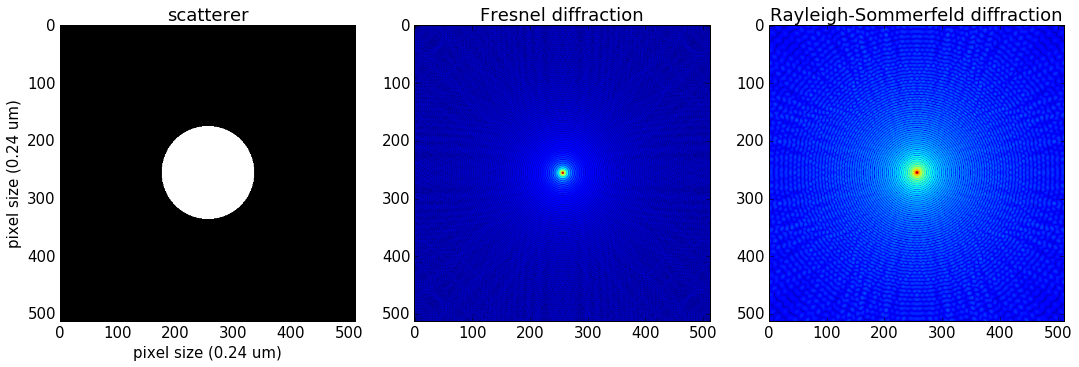

In [53]:
waveLen = 500E-9
pixelSize = 6.E-6
r = 20.E-6
z = 1.5E-3

diffObj = diffractor(waveLen, pixelSize, N_pix=512)
diffObj.setup_detector_distance(z)
diffObj.make_circ_aperture(r)
#diffObj.make_square_aperture(r)
print "Fresnel number: ", diffObj.z / (0.25*r*r/waveLen)

t0 = time.time()
scatterer = diffObj.obj
fresnel_pattern = np.abs(diffObj.Fresnel())**0.2
raysom_pattern = np.abs(diffObj.Rayleigh_Sommerfeld())**0.2
print("Took %0.1lf s"%(time.time()-t0))

show_diffraction_series(scatterer, fresnel_pattern, raysom_pattern, 
                        diffObj.res, tt2="Rayleigh-Sommerfeld diffraction")

In [54]:
13*(16)

208

# Alok
## Document what you did with clear and concise comments.

### Determine if the user should use either Fresnel or Fraunhofer diffraction. 
The user needs to input waveLen, pixelSize (number of pixels is optional), setup_detector_distance(z), and create either a circular or square aperture.
- Implement the class's functions, for computing Fresnel and Fraunhofer criteria.
- Implement a class function that computes if one should do Fresnel or Fraunhofer diffraction.

### Relate Fraunhofer to Fresnel diffraction.
- Create an circular aperture experiment at a particular aperture-detector distance, z_Frau, where Fraunhofer diffraction applies. 
- Show that z_Frau can be split into n integer distances, n*z_Fres, where z_Fres satisfies the Fresnel criteria.
- Show that propagating the wavefield via Fresnel diffraction n times, each at distance z_Fres, results in the Fraunhofer diffraction. (Hint: you will have to propagate the complex wavefield by using the Fresnel(showPhase=True). You will also need to manually change the object's self.obj. 

# Dushan
## Document what you did with clear and concise comments.
1. Insert up to 2-lines of """comments""" after the major functions in the diffractor class.
2. Implement a new propagator based on the Rayleigh-Sommerfeld propagator (equation 4-9).
3. Compare the Rayleigh-Sommerfeld propagated wave with both Fresnel and Fraunhofer diffraction.
4. Replace the diffractor class in /lib/diffraction.py with this new class.